In [10]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython import display

In [2]:
def do_graph_random_walks(adj_matrix, edge_indices, num_walks, walk_length):
    num_nodes = adj_matrix.shape[0]
    nodes = np.arange(num_nodes)
    trajectories = []
    for i in range(num_walks):
        trajectory = []
        curr_node = np.random.choice(nodes).item()
        for j in range(walk_length):
            next_node = np.random.choice(np.where(adj_matrix[curr_node] == 1)[0]).item()
            trajectory.append((curr_node, edge_indices[(curr_node, next_node)], next_node))
            curr_node = next_node
        trajectories.append(trajectory)
    return np.array(trajectories)

In [3]:
def gen_random_graph(n_nodes=32, min_degree=2, max_degree=5):
    degrees = np.random.randint(min_degree, max_degree + 1, (n_nodes,))
    if degrees.sum() % 2 != 0:
        adjust_idx = np.random.randint(n_nodes)
        if degrees[adjust_idx] == min_degree:
            degrees[adjust_idx] += 1
        elif degrees[adjust_idx] == max_degree:
            degrees[adjust_idx] -= 1
        else:
            adj = np.random.choice(np.array([-1, 1]))
            degrees[adjust_idx]=degrees[adjust_idx] + adj

    rem_degrees = np.copy(degrees)

    adj_matrix = np.zeros((n_nodes, n_nodes), dtype=np.uint8)
    edges = []
    edge_indices = {}
    edge_idx = 0
    while rem_degrees.sum() != 0:
        i = np.argmax(rem_degrees).item()
        rem_degrees_gz = rem_degrees > 0
        rem_degrees_not_argmax = np.arange(rem_degrees.size) != i
        pending_edges = np.where(rem_degrees_gz & rem_degrees_not_argmax)[0]
        j = np.random.choice(pending_edges).item()

        # find a better way to do this?
        if (i, j) in edges:
            continue

        edges.append((i,j))
        edge_indices[(i,j)] = edge_idx
        edge_idx += 1
        edges.append((j,i))
        edge_indices[(j,i)] = edge_idx
        edge_idx += 1
        rem_degrees[i] -= 1
        rem_degrees[j] -= 1

    for i, j in edges:
        adj_matrix[i, j] = 1

    return adj_matrix, edge_indices

In [4]:
adj_matrix, edge_indices = gen_random_graph()
num_walks = 200
walk_length = 32
trajectories = do_graph_random_walks(adj_matrix, edge_indices, num_walks, walk_length)

In [5]:
n_obs = adj_matrix.shape[0]
n_act = len(edge_indices)
emb_dim = 1000
Q_init_stddev = 1.0
V_init_stddev = 0.1
W_init_stddev = 0.1
eta_q = 0.1
eta_v = 0.01
eta_w = 0.01
num_epochs = 10

In [29]:
np.random.seed(0)
Q = np.random.normal(size=(emb_dim, n_obs)) * Q_init_stddev
V = np.random.normal(size=(emb_dim, n_act)) * V_init_stddev
W = np.random.normal(size=(n_act, emb_dim)) * W_init_stddev

In [30]:
num_trajectories = trajectories.shape[0]
mses1 = []
for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    for traj_idx in range(num_trajectories):
        nodes = trajectories[traj_idx, :, 0]
        edges = trajectories[traj_idx, :, 1]
        next_nodes = trajectories[traj_idx, :, 2]

        s_curr_DxL = Q[:, nodes]
        s_next_DxL = Q[:, next_nodes]

        s_diff_DxL = s_next_DxL - s_curr_DxL
        pred_err_DxL = s_diff_DxL - V[:, edges]

        V[:, edges] += eta_v * pred_err_DxL
        Q[:, next_nodes] += - eta_q * pred_err_DxL
        W[edges, :] += eta_w * s_diff_DxL.T
        mses1.append((pred_err_DxL ** 2).mean())

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


In [8]:
num_trajectories = trajectories.shape[0]
mses2 = []
for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    for traj_idx in range(num_trajectories):
        nodes = trajectories[traj_idx, :, 0]
        edges = trajectories[traj_idx, :, 1]
        next_nodes = trajectories[traj_idx, :, 2]
        
        cur_obs = np.zeros((Q.shape[1], len(nodes)))
        for idx, node in enumerate(nodes):
            cur_obs[node, idx] = 1
        next_obs = np.zeros((Q.shape[1], len(next_nodes)))
        for idx, node in enumerate(next_nodes):
            next_obs[node, idx] = 1
        actions = np.zeros((V.shape[1], len(edges)))
        for idx, edge in enumerate(edges):
            actions[edge, idx] = 1

        s_curr_DxL = Q@cur_obs
        s_next_DxL = Q@next_obs

        s_diff_DxL = s_next_DxL - s_curr_DxL
        pred_err_DxL = s_diff_DxL - V@actions

        V += eta_v * pred_err_DxL@actions.T
        Q += eta_q * pred_err_DxL@(- next_obs).T
        W += eta_w * actions@s_diff_DxL.T
        mses2.append((pred_err_DxL ** 2).mean())

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


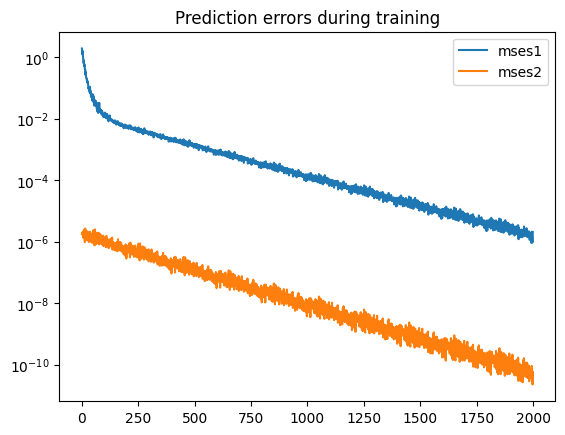

In [31]:
fig, ax = plt.subplots()
ax.plot(mses1, label='mses1')
ax.plot(mses2, label='mses2')
ax.set_title('Prediction errors during training')
ax.set_yscale('log')
plt.legend()
plt.show()
plt.close(fig)

In [32]:
def CML_planner(start, goal, obs_size):
    a_record = []
    o_record = []
    loc = int(start)
    for i in range(obs_size):
        o_record.append(loc)
        if loc==goal:
            return i, o_record
        cur_obs = np.zeros((Q.shape[1]))
        cur_obs[loc] = 1
        goal_obs = np.zeros((Q.shape[1]))
        goal_obs[goal] = 1
        delta = Q@goal_obs - Q@cur_obs  # TODO: start and goal are one-hot vector
        avail_nodes = np.where(adj_matrix[loc] == 1)[0]  # int64
        avail_actions = [edge_indices[(loc, int(next_node))] for next_node in avail_nodes]
        utility = delta.T@V[:, avail_actions]
        best_id = np.argmax(utility)
        best_action = avail_actions[best_id]
        loc = int(avail_nodes[best_id])
        a_record.append(best_action)
    return i, o_record

In [33]:
graph = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph())
start_id = 11
goal_id = 30
steps, o_record = CML_planner(start_id, goal_id, n_obs)
dijkstra_path = nx.shortest_path(graph, source=start_id, target=goal_id)
print(o_record, dijkstra_path)
dijkstra_steps = len(dijkstra_path) - 1

[11, 31, 30] [11, 1, 30]


In [42]:
N_goal = 1000
cml_distance = []
dijkstra_distance = []
graph = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph())
for _ in range(N_goal):
    start_id = np.random.randint(0, n_obs)
    goal_id = np.random.randint(0, n_obs)
    steps, o_record = CML_planner(start_id, goal_id, n_obs)
    dijkstra_path = nx.shortest_path(graph, source=start_id, target=goal_id)
    # print(o_record, dijkstra_path)
    dijkstra_steps = len(dijkstra_path) - 1
    cml_distance.append(steps)
    dijkstra_distance.append(dijkstra_steps)
# cml_distance, dijkstra_distance
np.mean(cml_distance), np.mean(dijkstra_distance)

(np.float64(4.302), np.float64(2.795))

# Gymnasium inverted pendulum

In [1]:
def dis_to_con(action_id, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (action_id /
                              (action_dim - 1)) * (action_upbound -
                                                   action_lowbound)

In [2]:
import gymnasium as gym
# The episode truncates at 200 time steps.
env = gym.make("Pendulum-v1", render_mode="rgb_array", g=9.81)  # default g=10.0

In [3]:
action_dim = 11
obs_dim = env.observation_space.shape[0]
obs_dim

3

In [11]:
env.reset()
for i in range(int(1e3)):
    action = env.action_space.sample()
    env.step(action)
    plt.imshow(env.render())
    display.display(plt.gcf())   
    display.clear_output(wait=True)

TypeError: size must be two numbers

In [12]:
trajs = []
traj_num = int(1e3)
for i in range(traj_num):
    # print(f"current traj num : {i}")
    cur_traj = []
    cur_obs, _ = env.reset(options={"low": -1, "high": 1})
    done = False
    trunk = False
    while not (done or trunk):
        action_id = np.random.choice(action_dim)
        action = dis_to_con(action_id, env, action_dim)
        obs, reward, done, trunk, _ = env.step([action])
        cur_traj.append(np.concatenate([cur_obs, [action_id], obs]))
        cur_obs = obs
        if done or trunk:
            trajs.append(cur_traj)

In [13]:
trajs_np = np.array(trajs)

In [14]:
emb_dim = 1000
Q_init_stddev = 1.0
V_init_stddev = 0.1
W_init_stddev = 0.1
eta_q = 0.0025
eta_v = 0.0005
eta_w = 0.0005
num_epochs = 10

In [15]:
np.random.seed(0)
Q = np.random.normal(size=(emb_dim, obs_dim)) * Q_init_stddev
V = np.random.normal(size=(emb_dim, action_dim)) * V_init_stddev
W = np.random.normal(size=(action_dim, emb_dim)) * W_init_stddev

In [17]:
mses2 = []
for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    for traj_idx, cur_traj in enumerate(trajs_np):
        cur_obs = cur_traj[:, :3].T
        next_obs = cur_traj[:, 4:].T
        # actions = np.zeros((action_dim, len(cur_traj)))
        # actions[cur_traj[:, 3].astype(np.int32), range(len(cur_traj))] = 1
        actions = cur_traj[:, 3].astype(np.int32)

        s_curr_DxL = Q@cur_obs
        s_next_DxL = Q@next_obs

        s_diff_DxL = s_next_DxL - s_curr_DxL
        # pred_err_DxL = s_diff_DxL - V@actions
        pred_err_DxL = s_diff_DxL - V[:, actions]

        # V += eta_v * pred_err_DxL@actions.T
        V[:, actions] += eta_v * pred_err_DxL
        Q += eta_q * pred_err_DxL@(cur_obs- next_obs).T
        # W += eta_w * actions@s_diff_DxL.T
        W[actions, :] += eta_w * s_diff_DxL.T
        mses2.append((pred_err_DxL ** 2).mean())

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


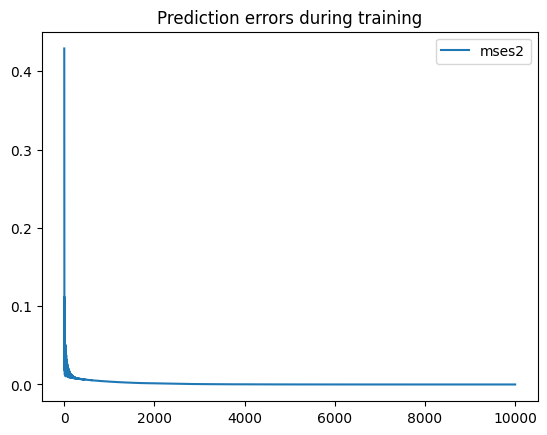

In [18]:
fig, ax = plt.subplots()
# ax.plot(mses1, label='mses1')
ax.plot(mses2, label='mses2')
ax.set_title('Prediction errors during training')
# ax.set_yscale('log')
plt.legend()
plt.show()
plt.close(fig)

In [19]:
def CML_controller(start, goal):
    delta = Q@goal - Q@start
    utility = delta.T@V
    best_id = np.argmax(utility)
    action = dis_to_con(best_id, env, action_dim)
    return action


In [20]:
env = gym.make("Pendulum-v1", render_mode="rgb_array", g=9.81)  # default g=10.0

KeyboardInterrupt: 

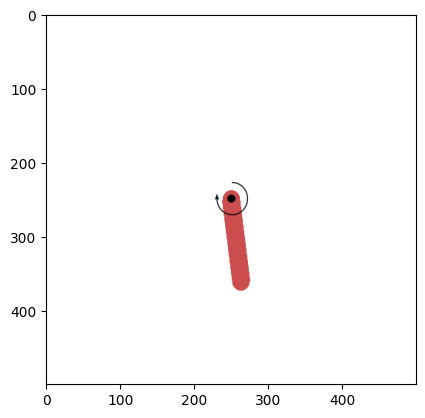

In [21]:
rewards = []
goal = np.array([0., 1., 0.])
for _ in range(100):
    cur_obs, _ = env.reset(options={"low": -1, "high": 1})
    done = False
    trunk = False
    episode_reward = 0
    while not (done or trunk):
        action = CML_controller(cur_obs, goal)
        cur_obs, reward, done, trunk, _ = env.step([action])
        episode_reward += reward
        plt.imshow(env.render())
        display.display(plt.gcf())   
        display.clear_output(wait=True)
        if done or trunk:
            print(done, trunk)
            rewards.append(episode_reward)

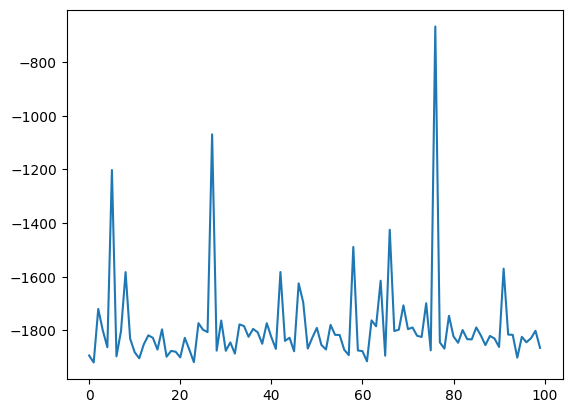

In [559]:
plt.plot(rewards)